The intention of this notebook is to track and summary the performances of the run models.

In [2]:
import sys
import os
import pickle
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sys.path.append('/home/ec2-user/SageMaker/projects/gnn/GNN-material/src')
sys.path = list(set(sys.path))

from tabulate import tabulate
from models.TabTab.tab_tab     import TabTab_v1, TabTabDataset, create_tab_tab_datasets, BuildTabTabModel
from models.GraphTab.graph_tab import GraphTab_v1, GraphTabDataset, create_graph_tab_datasets, BuildGraphTabModel
from models.TabGraph.tab_graph import TabGraph_v1, TabGraphDataset, create_tab_graph_datasets, BuildTabGraphModel

/home/ec2-user/anaconda3/envs/Thesis/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!ls -lh ../performances

total 59M
-rw-rw-r-- 1 ec2-user ec2-user 7.7K Dec  5 12:34 logfile_model_graphtab_700_gdsc2
-rw-rw-r-- 1 ec2-user ec2-user  25K Dec  5 15:19 logfile_model_graphtab_900_gdsc2
-rw-rw-r-- 1 ec2-user ec2-user  19K Dec  6 11:26 logfile_model_graphtab_gdsc2_990
-rw-rw-r-- 1 ec2-user ec2-user  17K Dec  5 16:08 logfile_model_tabgraph_900_gdsc2
-rw-rw-r-- 1 ec2-user ec2-user  19K Dec  5 19:04 logfile_model_tabgraph_gdsc2_990
-rw-rw-r-- 1 ec2-user ec2-user  16K Dec  5 10:20 logfile_model_tabtab_700_gdsc2
-rw-rw-r-- 1 ec2-user ec2-user 7.4K Dec  5 13:35 logfile_model_tabtab_900_gdsc2
-rw-rw-r-- 1 ec2-user ec2-user  19K Dec  5 17:40 logfile_model_tabtab_gdsc2_990
-rw-rw-r-- 1 ec2-user ec2-user 2.6M Dec  6 11:26 model_performance_GraphTab_gdsc2_990.pth
-rw-rw-r-- 1 ec2-user ec2-user 2.5M Dec  5 15:19 model_performance_GraphTab.pth
-rw-rw-r-- 1 ec2-user ec2-user  11M Dec  5 19:04 model_performance_TabGraph_gdsc2_990.pth
-rw-rw-r-- 1 ec2-user ec2-user  17M Dec  5 16:08 model_performance_TabGraph.pth


# Model Performances

## Helpers

In [27]:
def plot_model_results(df, model):
    fig, axs = plt.subplots(2, 4, figsize=(30, 10))

    sns.lineplot(x='epochs', y='mse', hue='dataset', data=df, ax=axs[0,0]);
    sns.lineplot(x='epochs', y='rmse', hue='dataset', data=df, ax=axs[0,1]);
    sns.lineplot(x='epochs', y='mae', hue='dataset', data=df, ax=axs[1,0]);
    sns.lineplot(x='epochs', y='pcorr', hue='dataset', data=df, ax=axs[1,1]);

    axs[0,0].set_title('MSE');
    axs[0,1].set_title('RMSE');
    axs[1,0].set_title('MAE');
    axs[1,1].set_title('Pearson Correlation');

    sns.boxplot(x='mse', y='dataset', data=df, showfliers=False, ax=axs[0,2]);
    sns.boxplot(x='rmse', y='dataset', data=df, showfliers=False, ax=axs[0,3]);
    sns.boxplot(x='mae', y='dataset', data=df, showfliers=False, ax=axs[1,2]);
    sns.boxplot(x='pcorr', y='dataset', data=df, showfliers=False, ax=axs[1,3]);

    axs[0,2].set_title('MSE'); axs[0,2].set(xlabel=None);
    axs[0,3].set_title('RMSE'); axs[0,3].set(xlabel=None);
    axs[1,2].set_title('MAE'); axs[1,2].set(xlabel=None);
    axs[1,3].set_title('Pearson Correlation'); axs[1,3].set(xlabel=None);

    fig.suptitle(f'{model} Model');
    plt.show();
    
class HyperParameters:
    def __init__(self, batch_size, lr, train_ratio, val_ratio, num_epochs, seed='12345', num_workers=0):
        self.BATCH_SIZE = batch_size
        self.LR = lr
        self.TRAIN_RATIO = train_ratio
        self.TEST_VAL_RATIO = 1-self.TRAIN_RATIO
        self.VAL_RATIO = val_ratio
        self.NUM_EPOCHS = num_epochs
        self.RANDOM_SEED = seed
        self.NUM_WORKERS = num_workers


def get_data_for_model_validation(mod, create, Model, BuildModel, drm, cl, sm, seed, approach):

    hyper_params = HyperParameters(batch_size=mod['batch_size'], 
                                   lr=mod['learning_rate'], 
                                   train_ratio=mod['train_ratio'], 
                                   val_ratio=mod['val_ratio'], 
                                   num_epochs=mod['epoch'], 
                                   seed=seed,
                                   num_workers=0)

    train_loader, test_loader, val_loader = create(drm, cl, sm, hyper_params)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if approach in ['TabTab', 'TabGraph']:
        model = Model(cl.shape[1]).to(device)
    elif approach == 'GraphTab':
        model = Model().to(device)
    model.load_state_dict(mod['model_state_dict'])
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(params=model.parameters(), 
                                 lr=mod['learning_rate'])    

    build_model = BuildModel(
        model=model, 
        criterion=loss_func, 
        optimizer=optimizer,
        num_epochs=mod['epoch'], 
        train_loader=train_loader,
        test_loader=test_loader, 
        val_loader=val_loader, 
        device=device
    )
    
    return build_model    

## 06.12.2022

In [28]:
# --- Results for combined_score_thresh=900 & GDSC2---
tt = torch.load('../performances/model_performance_TabTab_gdsc2_990.pth')
gt = torch.load('../performances/model_performance_GraphTab_gdsc2_990.pth')
tg = torch.load('../performances/model_performance_TabGraph_gdsc2_990.pth')
device = torch.device('cpu')
tt.keys()

dict_keys(['epoch', 'batch_size', 'learning_rate', 'train_ratio', 'val_ratio', 'model_state_dict', 'optimizer_state_dict', 'train_performances', 'val_performances'])

In [29]:
models = {
    'TabTab': tt,
    'GraphTab': gt,
    'TabGraph': tg
}

In [30]:
train_val_per_model = dict()

for name, res in models.items():
    ds = ['train', 'val']
    dfs = []
    for d in ds:
        epochs = range(1, tt['epoch']+1)
        mse = [x.item() for x in res[f'{d}_performances']['mse']]
        rmse = [x.item() for x in res[f'{d}_performances']['rmse']]
        mae = [x.item() for x in res[f'{d}_performances']['mae']]
        r2 = [x.item() for x in res[f'{d}_performances']['r2']]
        pcorr = [x[0] if d=='train' else x for x in tt[f'{d}_performances']['pcorr']]
        if d=='train':
            epochtimes = [x for x in res[f'{d}_performances']['epoch_times']]
        else: 
            epochtimes = [None for e in epochs]
        dfs.append(pd.DataFrame({
            'dataset': d,
            'epochs': epochs,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2,
            'pcorr': pcorr,
            'epoch_times': epochtimes
        }))  
        
    trainval = pd.concat([dfs[0], dfs[1]])
    train_val_per_model[name] = trainval
    
train_val_per_model.keys()

dict_keys(['TabTab', 'GraphTab', 'TabGraph'])

In [31]:
val_res = pd.DataFrame({
    'model': ['TabTab', 'GraphTab', 'TabGraph'],
    'mse': [None, None, None],
    'rmse': [None, None, None],
    'mae': [None, None, None],
    'r2': [None, None, None],
    'pcorr': [None, None, None]
})
val_res

,model,mse,rmse,mae,r2,pcorr
0,TabTab,None,None,None,None,None
1,GraphTab,None,None,None,None,None
2,TabGraph,None,None,None,None,None


## TabTab

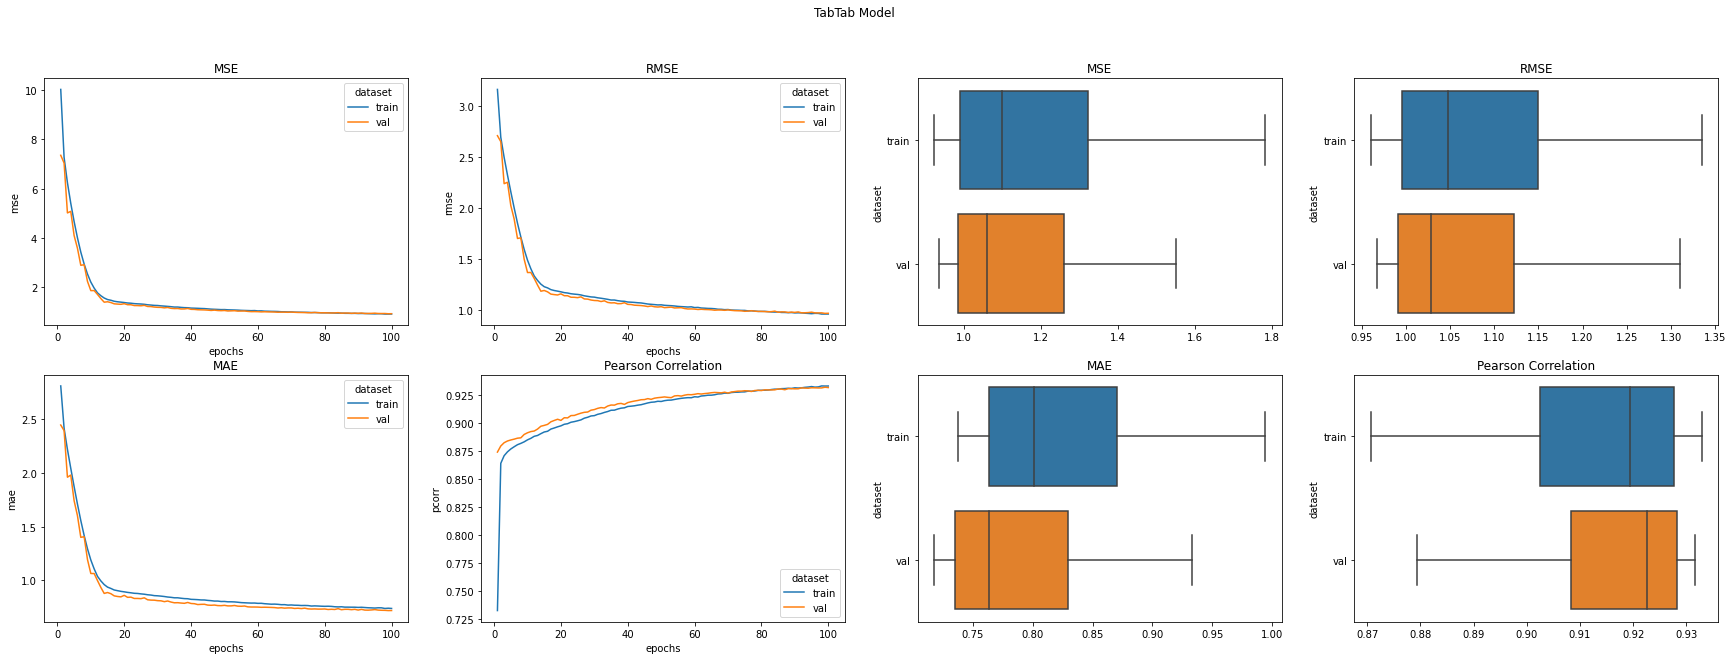

In [110]:
plot_model_results(train_val_per_model['TabTab'], 'TabTab')

In [32]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_mat.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_mat.pkl', 'rb') as f:
    smiles = pickle.load(f)
cl.set_index('CELL_LINE_NAME', inplace=True)
smiles.set_index('DRUG_ID', inplace=True)    

model = get_data_for_model_validation(
    tt, 
    create_tab_tab_datasets,
    TabTab_v1, 
    BuildTabTabModel,
    drm, 
    cl, 
    smiles,
    seed,
    'TabTab'
)

In [33]:
tr_mse, tr_rmse, tr_mae, tr_r2, tr_r = model.validate(model.train_loader)
val_mse, val_rmse, val_mae, val_r2, val_r = model.validate(model.val_loader)
te_mse, te_rmse, te_mae, te_r2, te_r = model.validate(model.test_loader)

val_res.iloc[val_res.model=='TabTab', 1:] = pd.Series([val_mse.item(), val_rmse.item(), val_mae, val_r2, val_r])

results = tabulate(
    [
        ['mse', 'rmse', 'mae', 'r2', 'r'],
        ['train', tr_mse, tr_rmse, tr_mae, tr_r2, tr_r],
        ['validation', val_mse, val_rmse, val_mae, val_r2, val_r],
        ['test', te_mse, te_rmse, te_mae, te_r2, te_r]
    ], headers='firstrow')
print(results)

Iteration (Val): 100%|██████████| 14/14 [00:04<00:00,  2.86it/s]

                 mse      rmse       mae        r2         r
----------  --------  --------  --------  --------  --------
train       0.701774  0.83772   0.635753  0.901149  0.949452
validation  0.937737  0.968368  0.717931  0.867462  0.931427
test        0.9352    0.967057  0.71581   0.868427  0.931941


## GraphTab

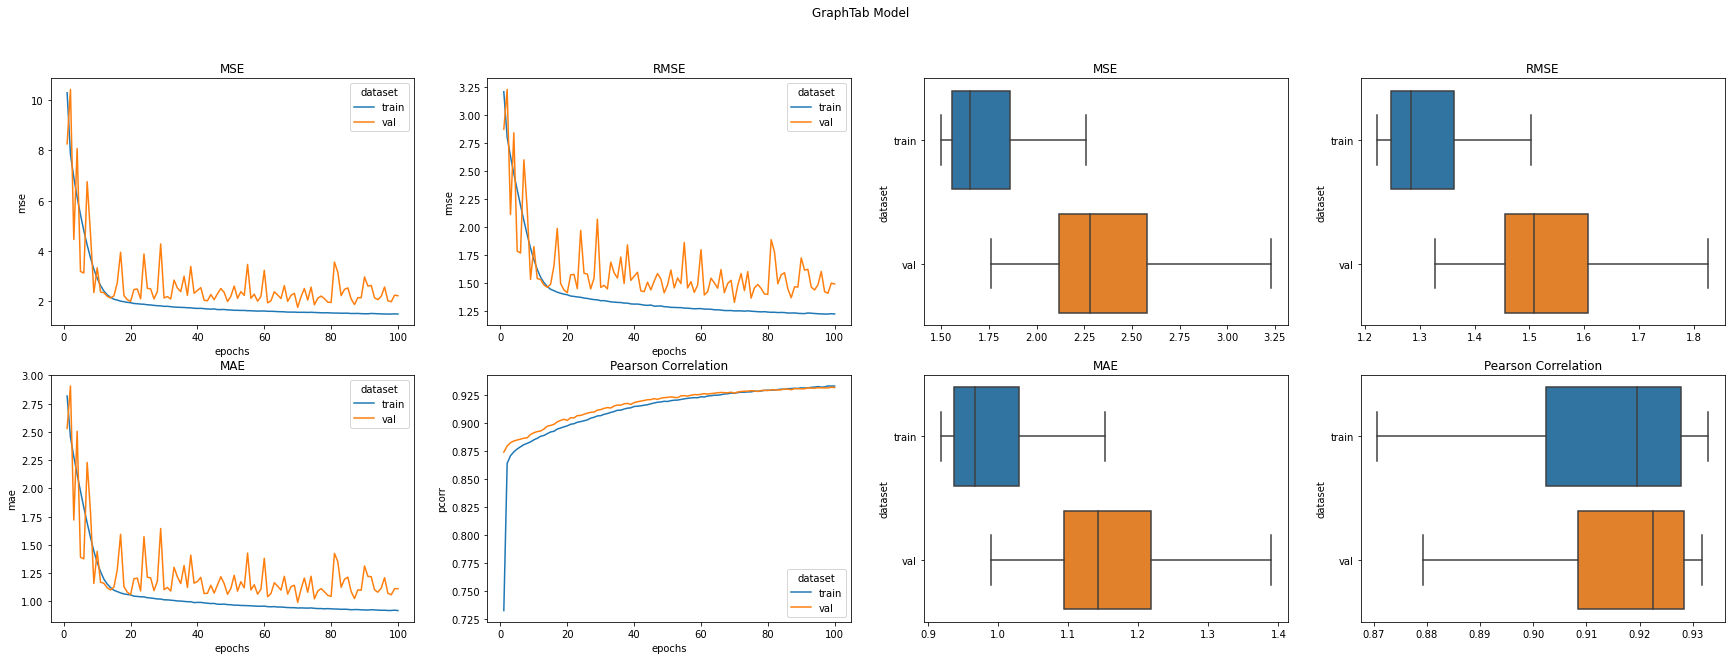

In [111]:
plot_model_results(train_val_per_model['GraphTab'], 'GraphTab')

In [34]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_graphs.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_dict.pkl', 'rb') as f:
    smiles = pickle.load(f)   

model = get_data_for_model_validation(
    gt, 
    create_graph_tab_datasets,
    GraphTab_v1, 
    BuildGraphTabModel,
    drm, 
    cl, 
    smiles,
    seed,
    'GraphTab'
)

In [35]:
tr_mse, tr_rmse, tr_mae, tr_r2, tr_r = model.validate(model.train_loader)
val_mse, val_rmse, val_mae, val_r2, val_r = model.validate(model.val_loader)
te_mse, te_rmse, te_mae, te_r2, te_r = model.validate(model.test_loader)

val_res.iloc[val_res.model=='GraphTab', 1:] = pd.Series([val_mse.item(), val_rmse.item(), val_mae, val_r2, val_r])

results = tabulate(
    [
        ['mse', 'rmse', 'mae', 'r2', 'r'],
        ['train', tr_mse, tr_rmse, tr_mae, tr_r2, tr_r],
        ['validation', val_mse, val_rmse, val_mae, val_r2, val_r],
        ['test', te_mse, te_rmse, te_mae, te_r2, te_r]
    ], headers='firstrow')
print(results)

Iteration (Val): 100%|██████████| 14/14 [00:14<00:00,  1.06s/it]

                mse     rmse      mae        r2         r
----------  -------  -------  -------  --------  --------
train       2.13278  1.4604   1.09569  0.699615  0.84734
validation  2.21904  1.48964  1.11147  0.687005  0.840099
test        2.20378  1.48451  1.10891  0.690293  0.841992


## TabGraph

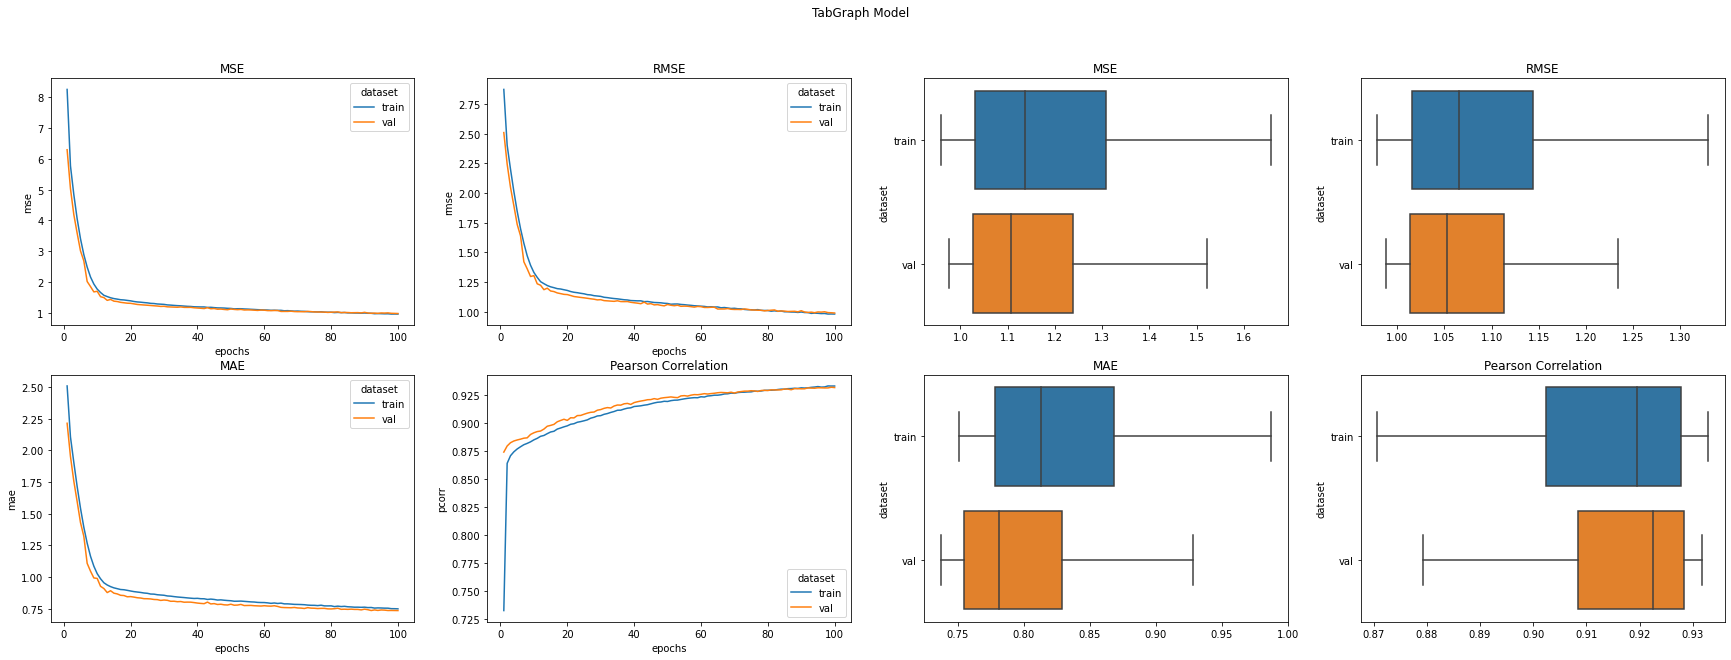

In [112]:
plot_model_results(train_val_per_model['TabGraph'], 'TabGraph')

In [36]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

with open('../../data/processed/' + 'gdsc2_drm.pkl', 'rb') as f: 
    drm = pickle.load(f)
with open('../../data/processed/gdsc2/990/' + f'thresh_gdsc2_990_gene_mat.pkl', 'rb') as f: 
    cl = pickle.load(f)
with open('../../data/processed/gdsc2/' + f'gdsc2_smiles_graphs.pkl', 'rb') as f:
    smiles = pickle.load(f)   
cl.set_index('CELL_LINE_NAME', inplace=True)
    
model = get_data_for_model_validation(
    tg, 
    create_tab_graph_datasets,
    TabGraph_v1, 
    BuildTabGraphModel,
    drm, 
    cl, 
    smiles,
    seed,
    'TabGraph'
)

In [37]:
tr_mse, tr_rmse, tr_mae, tr_r2, tr_r = model.validate(model.train_loader)
val_mse, val_rmse, val_mae, val_r2, val_r = model.validate(model.val_loader)
te_mse, te_rmse, te_mae, te_r2, te_r = model.validate(model.test_loader)

val_res.iloc[val_res.model=='TabGraph', 1:] = pd.Series([val_mse.item(), val_rmse.item(), val_mae, val_r2, val_r])

results = tabulate(
    [
        ['mse', 'rmse', 'mae', 'r2', 'r'],
        ['train', tr_mse, tr_rmse, tr_mae, tr_r2, tr_r],
        ['validation', val_mse, val_rmse, val_mae, val_r2, val_r],
        ['test', te_mse, te_rmse, te_mae, te_r2, te_r]
    ], headers='firstrow')
print(results)

Iteration (Val): 100%|██████████| 14/14 [00:05<00:00,  2.50it/s]

                 mse      rmse       mae        r2         r
----------  --------  --------  --------  --------  --------
train       0.750131  0.866101  0.660584  0.894393  0.946019
validation  0.976124  0.98799   0.736819  0.862292  0.928834
test        0.978758  0.989322  0.735769  0.862838  0.929099


# Summary

For the following configurations
- number of epochs: 100
- combined score threshold: 990
- learning rate: 0.0001
- batch size: 1000
- seed: 42
the results for the test test are:


In [42]:
val_res.to_csv('../performances/summary_val_gdsc2_val_100epochs.csv', index=False)
val_res

,model,mse,rmse,mae,r2,pcorr
0,TabTab,0.937737,0.968368,0.717931,0.867462,0.931427
1,GraphTab,2.219041,1.489644,1.111468,0.687005,0.840099
2,TabGraph,0.976124,0.987990,0.736819,0.862292,0.928834
